In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv

## Reading

In [120]:
plt.rcParams['figure.figsize'] = [8, 3]
plt.rcParams['figure.dpi'] = 100

In [121]:
row_start = 14

In [151]:
metadata = dict()
filename = "lorentzian/T0004ALL.CSV"
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for (i, row) in enumerate(reader):
        if i > row_start: break
        if len(row) >= 2: metadata[row[0]] = row[1]
metadata

{'Model': 'MSO2024B',
 'Firmware Version': '1.56',
 'Point Format': 'Y',
 'Horizontal Units': 'S',
 'Horizontal Scale': '1e-05',
 'Sample Interval': '1e-09',
 'Filter Frequency': '2e+08',
 'Record Length': '100000',
 'Gating': '0.0% to 100.0%',
 'Probe Attenuation': '1',
 'Vertical Units': 'V',
 'Vertical Offset': '0',
 'Vertical Scale': '0.5',
 'Label': ''}

In [152]:
data = pd.read_csv(filename, delimiter=",", header=row_start)
data

,TIME,CH1,CH3
0,0.01295,0.04,0.03
1,0.01295,0.04,0.05
2,0.01295,0.04,0.03
3,0.01295,0.06,0.03
4,0.01295,0.06,0.03
...,...,...,...
99995,0.01305,0.04,0.03
99996,0.01305,0.06,0.01
99997,0.01305,0.06,0.01
99998,0.01305,0.06,0.01


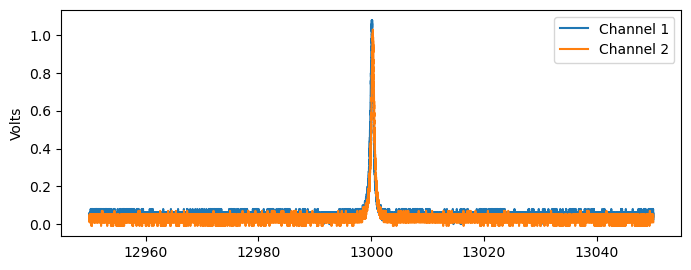

In [174]:
t_raw = data["TIME"].to_numpy()*1e6
ch1_raw = data["CH1"].to_numpy()
ch2_raw = data["CH3"].to_numpy()
plt.plot(
    t_raw, 
    ch1_raw,
    label="Channel 1"
)
plt.plot(
    t_raw, 
    ch2_raw,
    label="Channel 2"
)

plt.ylabel("Volts")
plt.legend()

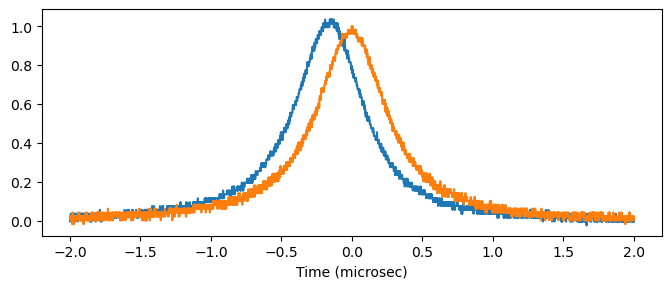

In [189]:
near = np.abs(t_raw - t_raw[np.argmax(ch2_raw)])
select = near < 2
antiselect = near > 3

t = t_raw[select]
t -= np.mean(t)

ch1 = ch1_raw[select] - np.mean(ch1_raw[antiselect])
ch2 = ch2_raw[select] - np.mean(ch2_raw[antiselect])
plt.plot(t, ch1)
plt.plot(t, ch2)
plt.xlabel("Time (microsec)")
plt.show()

In [190]:
curve = lambda t, A, g: A / (1 + (t/g)**2)

double = lambda t, A, g, h, x, y: curve(t-x, A, g) + curve(t-y, A, h)
delayed = lambda t, A, g, x: curve(t-x, A, g)

((1.0314802610669105, 0.9836166436903826),
 (0.2783642925570313, 0.28808457374083934),
 (-0.16256453525889483, -0.004331936830685783))

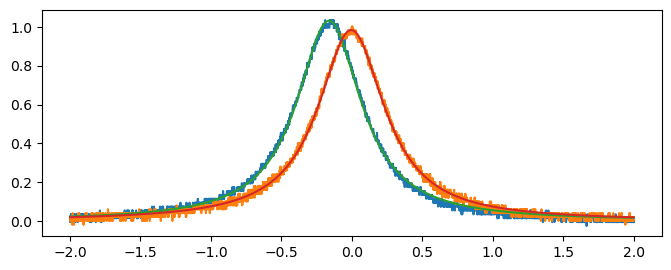

In [191]:
[[A1, g1, x1], cov1] = sp.optimize.curve_fit(delayed, t, ch1, p0=[2, 0.3, 0])
[[A2, g2, x2], cov2] = sp.optimize.curve_fit(delayed, t, ch2, p0=[2, 0.3, 0])


plt.plot(t, ch1)
plt.plot(t, ch2)
plt.plot(t, delayed(t, A1, g1, x1))
plt.plot(t, delayed(t, A2, g2, x2))

(A1, A2),(g1, g2), (x1, x2)

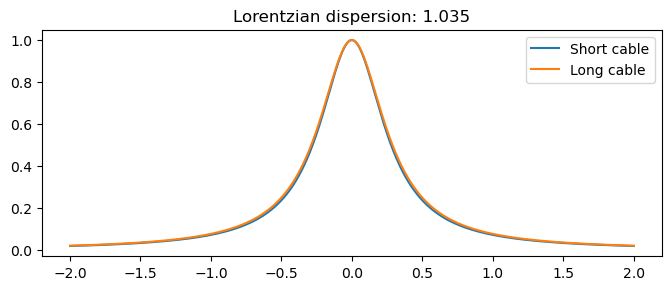

In [201]:
plt.title(f"Lorentzian dispersion: {g2/g1:.3f}")
plt.plot(t, curve(t, 1, g1), label="Short cable")
plt.plot(t, curve(t, 1, g2), label="Long cable")
plt.legend()
plt.show()

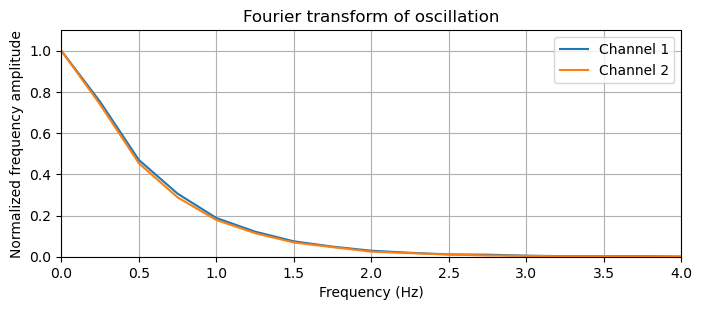

In [196]:
from scipy.fft import fft, fftfreq, fftshift

for (n, ch) in enumerate([ch1, ch2]):
    spectrum = np.abs(fftshift(fft(ch)))
    spectrum /= np.max(spectrum)
    sampling_rate = 1 / np.average(np.diff(t))
    freq = fftshift(fftfreq(t.size, 1/sampling_rate))
    bin_width = np.average(np.diff(freq))
    plt.plot(freq, spectrum, label=f"Channel {n+1}")

plt.title("Fourier transform of oscillation")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized frequency amplitude")
plt.xlim(0, 4)
plt.ylim(0, 1.1)
plt.grid()
plt.legend()
plt.show()